In [1]:
%pip install nltk

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import re
import nltk

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')


Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [2]:
VOCAB_LIMIT = 10000
SEQUENCE_LEN = 100
EMBED_SIZE = 200
VAL_SPLIT = 0.2
SEED = 42
BATCH = 32
EPOCH_MAX = 20


In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Initial Dataset Info:")
print("-" * 40)
print("Train set dimensions:", df_train.shape)
print("Test set dimensions:", df_test.shape)
print("Train columns:", df_train.columns.tolist())
print("\nNull values in train:\n", df_train.isnull().sum())
print("\nTweet samples:\n", df_train['text'].head())


Initial Dataset Info:
----------------------------------------
Train set dimensions: (7613, 5)
Test set dimensions: (3263, 4)
Train columns: ['id', 'keyword', 'location', 'text', 'target']

Null values in train:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Tweet samples:
 0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object


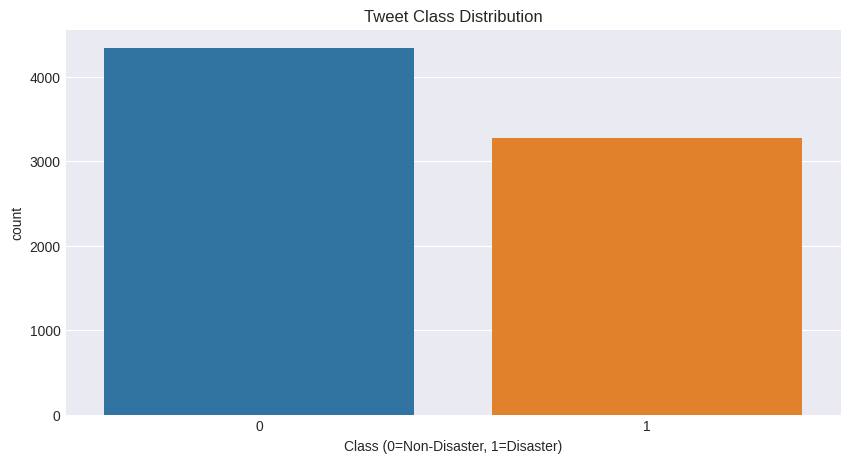

Class percentage breakdown:
target
0    57.0
1    43.0
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


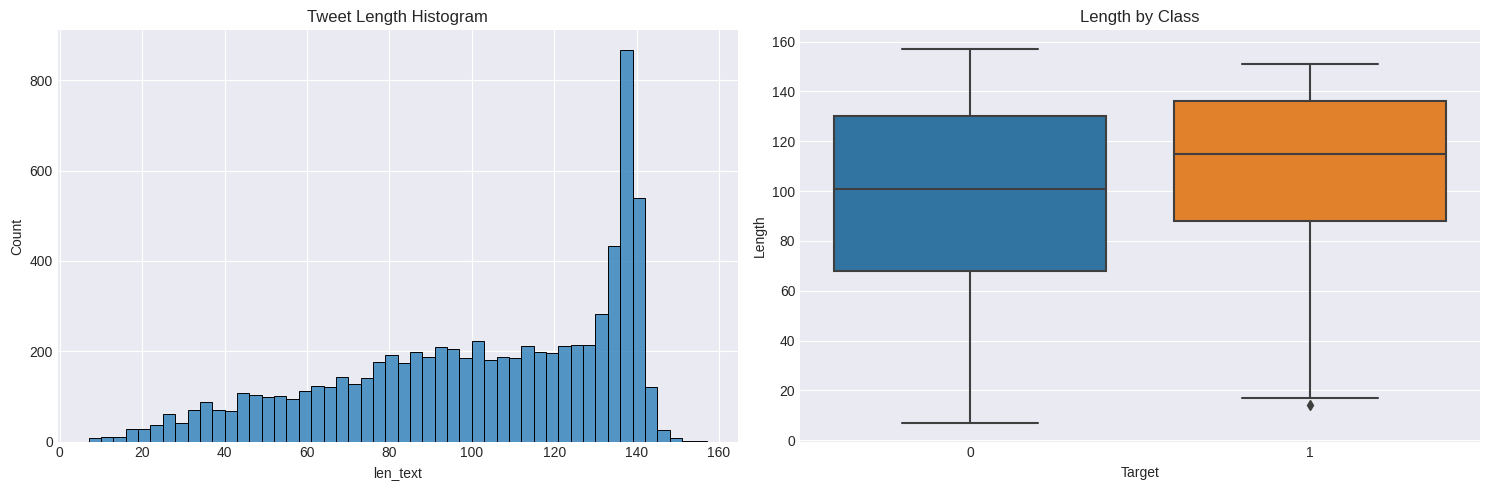

In [4]:
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='target')
plt.title('Tweet Class Distribution')
plt.xlabel('Class (0=Non-Disaster, 1=Disaster)')
plt.show()

print("Class percentage breakdown:")
print(df_train['target'].value_counts(normalize=True).round(3) * 100)

df_train['len_text'] = df_train['text'].str.len()
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='len_text', bins=50)
plt.title('Tweet Length Histogram')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_train, x='target', y='len_text')
plt.title('Length by Class')
plt.xlabel('Target')
plt.ylabel('Length')

plt.tight_layout()
plt.show()


In [5]:
def clean_text(raw_text):
    if pd.isna(raw_text):
        return ''
    raw_text = raw_text.lower()
    raw_text = re.sub(r'http\S+|www\S+|https\S+', '', raw_text)
    raw_text = re.sub(r'@\w+', '', raw_text)
    raw_text = re.sub(r'#(\w+)', r'\1', raw_text)
    raw_text = re.sub(r'[^\w\s]', '', raw_text)
    raw_text = re.sub(r'\d+', '', raw_text)
    raw_text = ' '.join(raw_text.split())
    
    stop_words_set = set(stopwords.words('english'))
    tokenized = word_tokenize(raw_text)
    filtered = [word for word in tokenized if word not in stop_words_set]
    
    return ' '.join(filtered)

df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

for i in range(3):
    print(f"\nOriginal: {df_train['text'].iloc[i]}")
    print(f"Cleaned : {df_train['text_clean'].iloc[i]}")



Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned : deeds reason earthquake may allah forgive us

Original: Forest fire near La Ronge Sask. Canada
Cleaned : forest fire near la ronge sask canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned : residents asked shelter place notified officers evacuation shelter place orders expected


In [6]:
text_encoder = Tokenizer(num_words=VOCAB_LIMIT, oov_token='<OOV>')
text_encoder.fit_on_texts(df_train['text_clean'])

seq_train = text_encoder.texts_to_sequences(df_train['text_clean'])
seq_test = text_encoder.texts_to_sequences(df_test['text_clean'])

pad_train = pad_sequences(seq_train, maxlen=SEQUENCE_LEN, padding='post')
pad_test = pad_sequences(seq_test, maxlen=SEQUENCE_LEN, padding='post')

label = df_train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    pad_train, label, 
    test_size=VAL_SPLIT, 
    random_state=SEED, 
    stratify=label
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


Train shape: (6090, 100)
Val shape: (1523, 100)


In [7]:
classifier = Sequential([
    Embedding(VOCAB_LIMIT + 1, EMBED_SIZE, input_length=SEQUENCE_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

classifier.summary()

model_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6)
]

training_history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCH_MAX,
    batch_size=BATCH,
    callbacks=model_callbacks
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6086 - loss: 0.6484 - val_accuracy: 0.8037 - val_loss: 0.4508 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8660 - loss: 0.3391 - val_accuracy: 0.7899 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9175 - loss: 0.2310 - val_accuracy: 0.7912 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9510 - loss: 0.1462 - val_accuracy: 0.7800 - val_loss: 0.6683 - learning_rate: 2.0000e-04


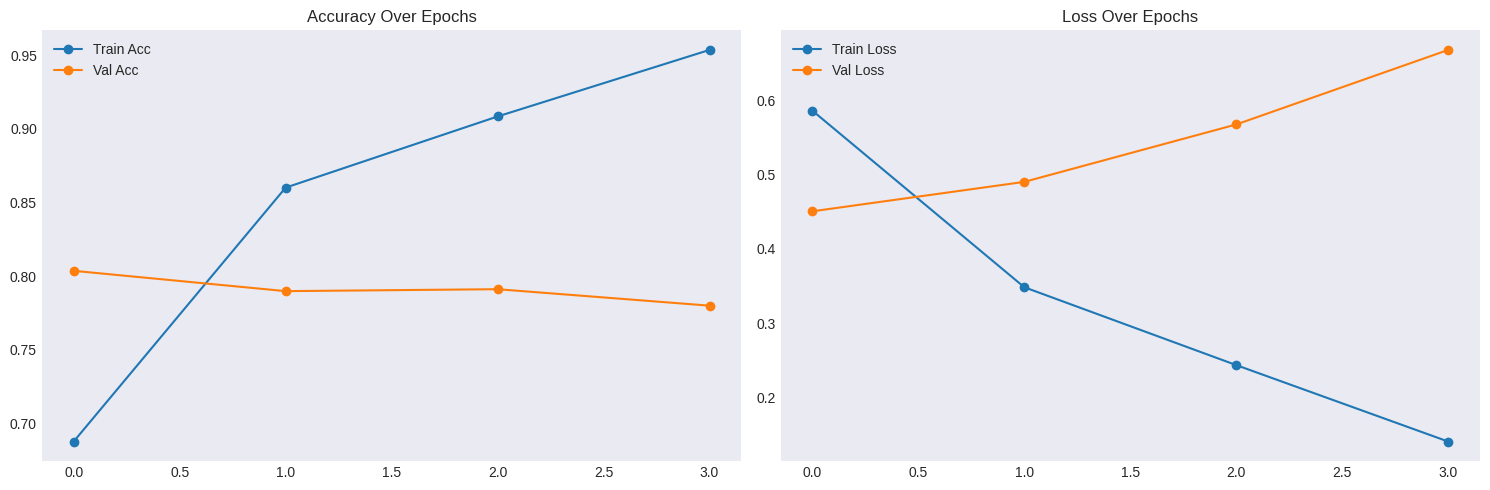

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Metrics:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       869
           1       0.84      0.67      0.75       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



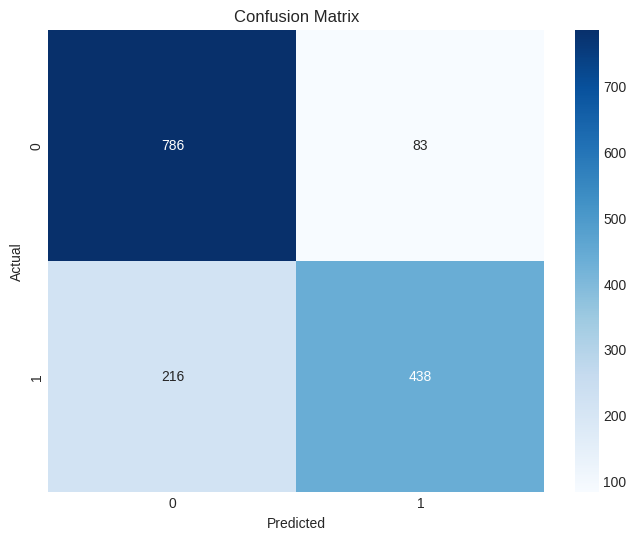

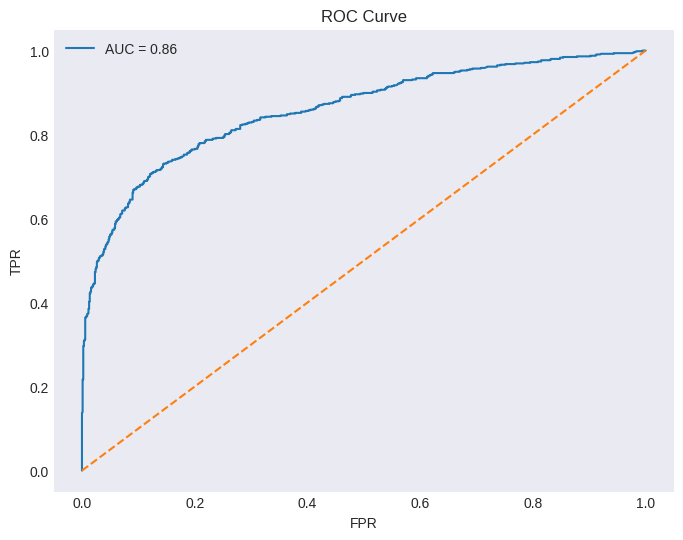

Final Train Accuracy: 0.9535
Final Val Accuracy: 0.7800


In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(training_history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Train Loss', marker='o')
plt.plot(training_history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

y_pred_prob = classifier.predict(X_val)
y_pred_label = (y_pred_prob > 0.5).astype(int)

print("Classification Metrics:")
print(classification_report(y_val, y_pred_label))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_label), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_prob)
roc_val_auc = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label=f"AUC = {roc_val_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

print(f"Final Train Accuracy: {training_history.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {training_history.history['val_accuracy'][-1]:.4f}")


In [11]:
final_predictions = (classifier.predict(pad_test) > 0.5).astype(int)

sub_file = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sub_file['target'] = final_predictions
sub_file.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Submission file created: submission.csv
